##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Aprendizaje por transferencia y refinamiento

Este cuaderno es una versión revisada de la traducción automática de un tutorial de TensorFlow.org, que pueden ver online en https://www.tensorflow.org/tutorials/images/transfer_learning?hl=es-419 u obtener con los enlaces de abajo.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb?force_kitty_mode=1&force_corgi_mode=1"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

En este tutorial, aprenderá a clasificar imágenes de gatos y perros utilizando el aprendizaje por transferencia de una red previamente entrenada.

Un modelo preentrenado es una red guardada que se entrenó previamente en un gran conjunto de datos, generalmente en una tarea de clasificación de imágenes a gran escala. Puede usar el modelo preentrenado tal como está o usar el aprendizaje por transferencia para personalizar este modelo para una tarea determinada.

La intuición detrás del aprendizaje por transferencia para la clasificación de imágenes es que si un modelo se entrena en un conjunto de datos lo suficientemente grande y general, este modelo servirá efectivamente como un modelo genérico del mundo visual. A continuación, puede aprovechar estos mapas de características aprendidos sin tener que empezar de cero entrenando un modelo grande en un conjunto de datos grande.

En este cuaderno, probará dos formas de personalizar un modelo previamente entrenado:

1. Extracción de características: use las representaciones aprendidas por una red anterior para extraer características significativas de nuevas muestras. Simplemente agregue un nuevo clasificador, que se entrenará desde cero, encima del modelo previamente entrenado para que pueda reutilizar los mapas de características aprendidos previamente para el conjunto de datos.

   No necesita (re)entrenar todo el modelo. La red convolucional base ya contiene características que son genéricamente útiles para clasificar imágenes. Sin embargo, la parte de clasificación final del modelo preentrenado es específica de la tarea de clasificación original y, posteriormente, específica del conjunto de clases en las que se entrenó el modelo.

2. Ajuste fino: descongele algunas de las capas superiores de una base de modelo congelada y entrene conjuntamente las capas clasificadoras recién agregadas y las últimas capas del modelo base. Esto nos permite "afinar" las representaciones de características de orden superior en el modelo base para que sean más relevantes para la tarea específica.

Seguirá el flujo de trabajo general de aprendizaje automático.

1. Examinar y comprender los datos.
2. Crear una tubería de entrada, en este caso usando Keras ImageDataGenerator
3. Componer el modelo
   * Carga en el modelo base preentrenado (y pesos preentrenados)
   * Apila las capas de clasificación en la parte superior
4. Entrenar al modelo
5. Evaluar modelo

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Preprocesamiento de datos

### Descarga de datos

En este tutorial, utilizará un conjunto de datos que contiene varios miles de imágenes de gatos y perros. Descargue y extraiga un archivo zip que contenga las imágenes, luego cree un `tf.data.Dataset` para entrenamiento y validación usando la utilidad `tf.keras.utils.image_dataset_from_directory`. Puede obtener más información sobre cómo cargar imágenes en este [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

Descarga ~65MB

In [4]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

68606236/68606236 [==============================] - 283s 4us/step
Found 2000 files belonging to 2 classes.


In [5]:
print("Imágenes descargadas a: {}".format(PATH))

Imágenes descargadas a: C:\Users\Christian\.keras\datasets\cats_and_dogs_filtered


In [6]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Muestre las primeras nueve imágenes y etiquetas del conjunto de entrenamiento:

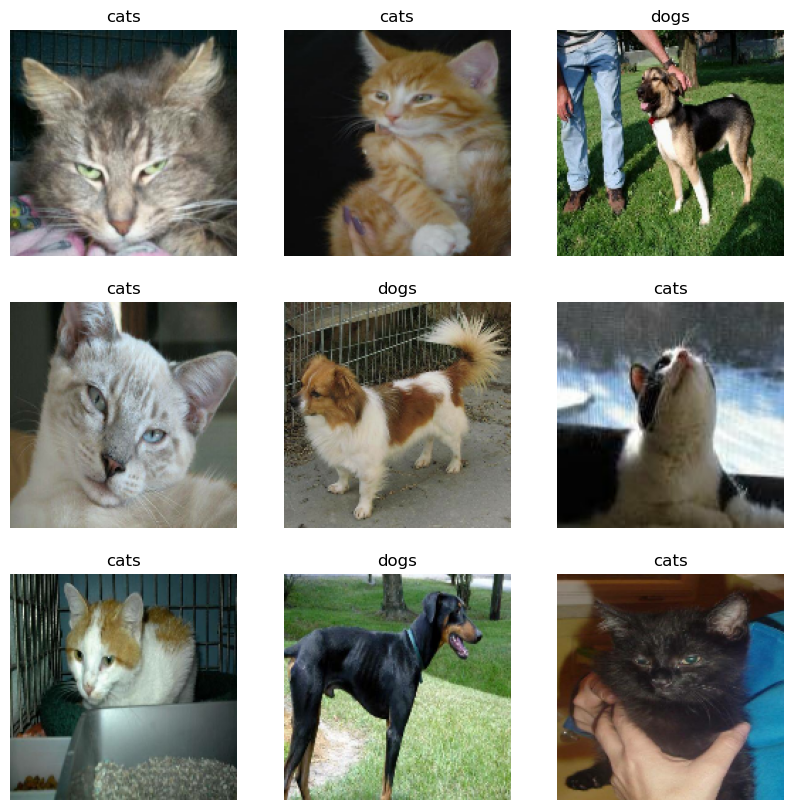

In [7]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Como el conjunto de datos original no contiene un conjunto de prueba, creará uno. Para hacerlo, determine cuántos lotes de datos están disponibles en el conjunto de validación mediante `tf.data.experimental.cardinality`, y luego mueva el 20 % de ellos a un conjunto de prueba..

In [8]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [9]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Configurar el conjunto de datos para el rendimiento

Usar la captación previa almacenada en búfer para cargar imágenes desde el disco sin que la E/S se convierta en un bloqueo. Para obtener más información sobre este método, consulte la guía  [data performance](https://www.tensorflow.org/guide/data_performance).

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Usar aumento de datos

Cuando no tiene un conjunto de datos de imágenes grande, es una buena práctica introducir artificialmente diversidad de muestras mediante la aplicación de transformaciones aleatorias pero realistas a las imágenes de entrenamiento, como la rotación y el volteo horizontal. Esto ayuda a exponer el modelo a diferentes aspectos de los datos de entrenamiento y reduce el [sobreajuste](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). Puede obtener más información sobre el aumento de datos en este [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Nota: estas capas solo están activas durante el entrenamiento, cuando llamas a `Model.fit` . Están inactivos cuando el modelo se usa en modo de inferencia en `Model.evaluate` o `Model.fit` .

Apliquemos repetidamente estas capas a la misma imagen y veamos el resultado.

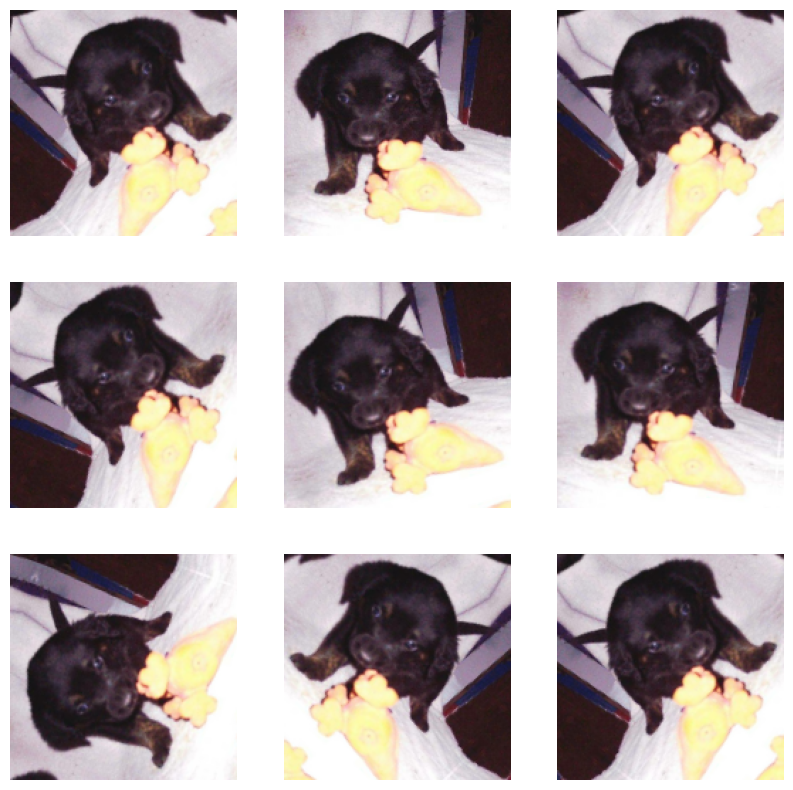

In [12]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Cambiar la escala de los valores de píxeles

En un momento, descargará `tf.keras.applications.MobileNetV2` para usarlo como su modelo base. Este modelo espera valores de píxel en `[-1, 1]` , pero en este punto, los valores de píxel en sus imágenes están en `[0, 255]`. Para volver a escalarlos, utilice el método de preprocesamiento incluido con el modelo.

In [13]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Nota: Alternativamente, puede cambiar la escala de los valores de píxeles de `[0, 255]` to `[-1, 1]` usando `tf.keras.layers.Rescaling`.

In [14]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Nota: si usa otras `tf.keras.applications` , asegúrese de consultar el documento de API para determinar si esperan píxeles en `[-1, 1]` o `[0, 1]` , o use la función `preprocess_input` incluida.

## Cree el modelo base a partir de las convnets preentrenadas

Creará el modelo base a partir del modelo **MobileNet V2** desarrollado en Google. Esto se entrena previamente en el conjunto de datos de ImageNet, un gran conjunto de datos que consta de 1,4 millones de imágenes y 1000 clases. ImageNet es un conjunto de datos de entrenamiento de investigación con una amplia variedad de categorías como `jackfruit` y `syringe` . Esta base de conocimientos nos ayudará a clasificar perros y gatos a partir de nuestro conjunto de datos específico.

Primero, debe elegir qué capa de MobileNet V2 utilizará para la extracción de características. La última capa de clasificación ("arriba", ya que la mayoría de los diagramas de modelos de aprendizaje automático van de abajo hacia arriba) no es muy útil. En su lugar, seguirá la práctica común de depender de la última capa antes de la operación de aplanado. Esta capa se denomina "capa de cuello de botella". Las características de la capa de cuello de botella conservan más generalidad en comparación con la capa final/superior.

Primero, cree una instancia de un modelo MobileNet V2 precargado con pesos entrenados en ImageNet. Al especificar el argumento **include_top=False** , carga una red que no incluye las capas de clasificación en la parte superior, lo que es ideal para la extracción de características.

In [15]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 38s 4us/step


Este extractor de características convierte cada imagen de `160x160x3` en un bloque de características de `5x5x1280` . Veamos qué le hace a un lote de imágenes de ejemplo:

In [16]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Extracción de características
En este paso, congelará la base convolucional creada en el paso anterior y la utilizará como extractor de características. Además, agrega un clasificador encima y entrena el clasificador de nivel superior.

### Congelar la base convolucional

Es importante congelar la base convolucional antes de compilar y entrenar el modelo. Congelar (estableciendo `layer.trainable = False`) evita que los pesos en una capa determinada se actualicen durante el entrenamiento. MobileNet V2 tiene muchas capas, por lo que establecer la bandera `trainable` de todo el modelo en `False` las congelará todas.

In [17]:
base_model.trainable = False

### Nota importante sobre las capas de BatchNormalization

Muchos modelos contienen capas `tf.keras.layers.BatchNormalization` . Esta capa es un caso especial y se deben tomar precauciones en el contexto del refinamiento, como se muestra más adelante en este tutorial.

Cuando establece `layer.trainable = False` , la capa `BatchNormalization` se ejecutará en modo de inferencia y no actualizará sus estadísticas de media y varianza.

Cuando descongela un modelo que contiene capas de `BatchNormalization` para realizar un refinamiento, debe mantener las capas de `BatchNormalization` en modo de inferencia pasando `training = False` al llamar al modelo base. De lo contrario, las actualizaciones aplicadas a los pesos no-entrenables destruirán lo aprendido por el modelo.

Para obtener más detalles, consulta la guía de [Aprendizaje por transferencia](https://www.tensorflow.org/guide/keras/transfer_learning).

In [18]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

### Agregar un encabezado de clasificación

Para generar predicciones a partir del bloque de entidades, promedie las ubicaciones espaciales de `5x5` utilizando una capa `tf.keras.layers.GlobalAveragePooling2D` para convertir las entidades en un único vector de 1280 elementos por imagen.

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Aplique una capa `tf.keras.layers.Dense` para convertir estas características en una sola predicción por imagen. No necesita una función de activación aquí porque esta predicción se tratará como un `logit` o un valor de predicción sin procesar. Los números positivos predicen la clase 1, los números negativos predicen la clase 0.

In [20]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Cree un modelo encadenando las capas de aumento de datos, reescalado, `base_model` y extractor de características mediante la [API funcional de Keras](https://www.tensorflow.org/guide/keras/functional). Como se mencionó anteriormente, use `training=False` ya que nuestro modelo contiene una capa `BatchNormalization` .

In [21]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compilar el modelo

Compile el modelo antes de entrenarlo. Dado que hay dos clases, use la pérdida `tf.keras.losses.BinaryCrossentropy` con `from_logits=True` ya que el modelo proporciona una salida lineal.

In [22]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

Los 2,5 millones de parámetros en MobileNet están congelados, pero hay 1,2 mil parámetros _entrenables_ en la capa densa. Estos se dividen entre dos objetos `tf.Variable`, los pesos y los sesgos.

In [24]:
len(model.trainable_variables)

2

### Entrenar al modelo

Después de entrenar durante 10 épocas, debería ver una precisión de ~94 % en el conjunto de validación.

In [25]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 8s 225ms/step - loss: 0.8135 - accuracy: 0.4901


In [26]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.81
initial accuracy: 0.49


In [27]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 27s 376ms/step - loss: 0.7269 - accuracy: 0.5745 - val_loss: 0.5581 - val_accuracy: 0.7067
Epoch 2/10
63/63 [==============================] - 26s 420ms/step - loss: 0.5403 - accuracy: 0.7120 - val_loss: 0.4106 - val_accuracy: 0.7933
Epoch 3/10
63/63 [==============================] - 25s 404ms/step - loss: 0.4393 - accuracy: 0.7800 - val_loss: 0.3190 - val_accuracy: 0.8465
Epoch 4/10
63/63 [==============================] - 26s 410ms/step - loss: 0.3764 - accuracy: 0.8180 - val_loss: 0.2590 - val_accuracy: 0.8861
Epoch 5/10
63/63 [==============================] - 24s 387ms/step - loss: 0.3329 - accuracy: 0.8440 - val_loss: 0.2150 - val_accuracy: 0.9121
Epoch 6/10
63/63 [==============================] - 26s 405ms/step - loss: 0.2925 - accuracy: 0.8710 - val_loss: 0.1880 - val_accuracy: 0.9233
Epoch 7/10
63/63 [==============================] - 25s 405ms/step - loss: 0.2634 - accuracy: 0.8815 - val_loss: 0.1717 - val_accuracy: 0.9295

### Curvas de aprendizaje

Echemos un vistazo a las curvas de aprendizaje de la precisión/pérdida de capacitación y validación cuando se usa el modelo base de MobileNetV2 como un extractor de características fijas.

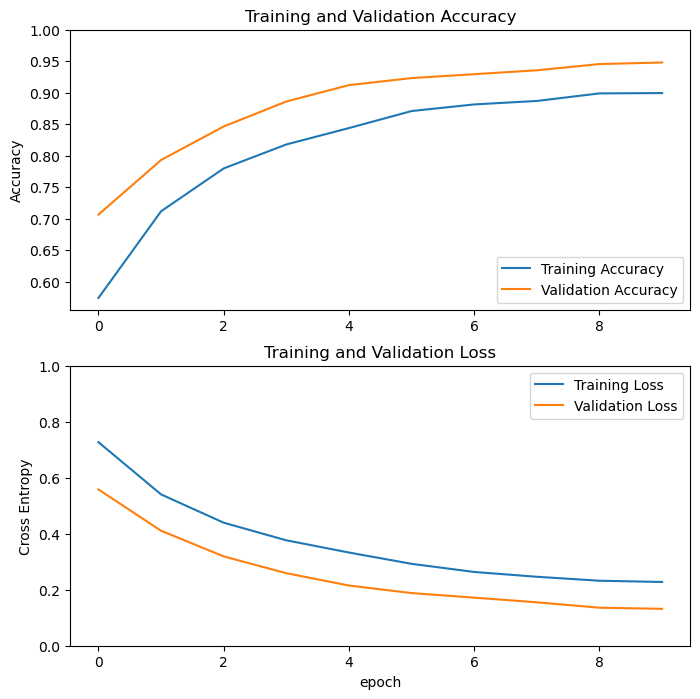

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Nota: si se pregunta por qué las métricas de validación son claramente mejores que las métricas de entrenamiento, el factor principal es que capas como `tf.keras.layers.BatchNormalization` y `tf.keras.layers.Dropout` afectan la precisión durante el entrenamiento. Se desactivan al calcular la pérdida de validación.

En menor medida, también se debe a que las métricas de entrenamiento informan el promedio de una época, mientras que las métricas de validación se evalúan después de la época, por lo que las métricas de validación ven un modelo que se ha entrenado un poco más.

## Refinamiento (fine tuning)

En el experimento de extracción de características, solo estaba entrenando algunas capas sobre un modelo base de MobileNetV2. Los pesos de la red preentrenada **no** se actualizaron durante el entrenamiento.

Una forma de aumentar aún más el rendimiento es entrenar (o "afinar") los pesos de las capas superiores del modelo preentrenado junto con el entrenamiento del clasificador que agregó. El proceso de entrenamiento obligará a ajustar los pesos de los mapas de características genéricas a las características asociadas específicamente con el conjunto de datos.

Nota: Esto solo debe intentarse después de haber entrenado el clasificador de nivel superior con el modelo preentrenado establecido en no-entrenable. Si agrega un clasificador inicializado aleatoriamente encima de un modelo previamente entrenado e intenta entrenar todas las capas juntas, la magnitud de las actualizaciones de gradiente será demasiado grande (debido a los pesos aleatorios del clasificador) y su modelo previamente entrenado olvidar lo que ha aprendido.

Además, debe intentar ajustar **una pequeña cantidad de capas superiores** en lugar de todo el modelo de MobileNet. En la mayoría de las redes convolucionales, cuanto más arriba está una capa, más especializada es. Las primeras capas aprenden características muy simples y genéricas que se generalizan a casi todos los tipos de imágenes. A medida que avanza, las funciones son cada vez más específicas para el conjunto de datos en el que se entrenó el modelo. El objetivo del ajuste fino es adaptar estas características especializadas para que funcionen con el nuevo conjunto de datos, en lugar de sobrescribir el aprendizaje genérico.

### Descongele las capas superiores del modelo.

Todo lo que necesita hacer es descongelar el `base_model` y configurar las capas inferiores para que no se puedan entrenar. Luego, debe volver a compilar el modelo (necesario para que estos cambios surtan efecto) y reanudar el entrenamiento.

In [29]:
base_model.trainable = True

In [30]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### Compilar el modelo

Como está entrenando un modelo mucho más grande y quiere readaptar los pesos previamente entrenados, es **importante** usar una tasa de aprendizaje más baja en esta etapa. De lo contrario, su modelo podría sobreajustarse muy rápidamente.

In [31]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [33]:
len(model.trainable_variables)

56

### Continuar entrenando al modelo

Si se entrenó antes para la convergencia, este paso mejorará su precisión en algunos puntos porcentuales.

In [34]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 37s 509ms/step - loss: 0.1657 - accuracy: 0.9290 - val_loss: 0.0601 - val_accuracy: 0.9777
Epoch 11/20
63/63 [==============================] - 34s 532ms/step - loss: 0.1200 - accuracy: 0.9500 - val_loss: 0.0523 - val_accuracy: 0.9839
Epoch 12/20
63/63 [==============================] - 37s 594ms/step - loss: 0.1080 - accuracy: 0.9550 - val_loss: 0.0453 - val_accuracy: 0.9839
Epoch 13/20
63/63 [==============================] - 35s 557ms/step - loss: 0.0966 - accuracy: 0.9580 - val_loss: 0.0442 - val_accuracy: 0.9851
Epoch 14/20
63/63 [==============================] - 35s 554ms/step - loss: 0.0906 - accuracy: 0.9635 - val_loss: 0.0407 - val_accuracy: 0.9827
Epoch 15/20
63/63 [==============================] - 33s 530ms/step - loss: 0.0702 - accuracy: 0.9740 - val_loss: 0.0440 - val_accuracy: 0.9839
Epoch 16/20
63/63 [==============================] - 34s 546ms/step - loss: 0.0776 - accuracy: 0.9665 - val_loss: 0.0383 - val_accuracy:

Echemos un vistazo a las curvas de aprendizaje de la precisión/pérdida de entrenamiento y validación cuando se ajustan las últimas capas del modelo base de MobileNetV2 y se entrena el clasificador encima. La pérdida de validación es mucho mayor que la pérdida de entrenamiento, por lo que es posible que se sobreajuste.

También es posible que se sobreajuste, ya que el nuevo conjunto de entrenamiento es relativamente pequeño y similar a los conjuntos de datos originales de MobileNetV2.

Después del refinamiento, el modelo alcanza casi el 98% de precisión en el conjunto de validación.

In [35]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

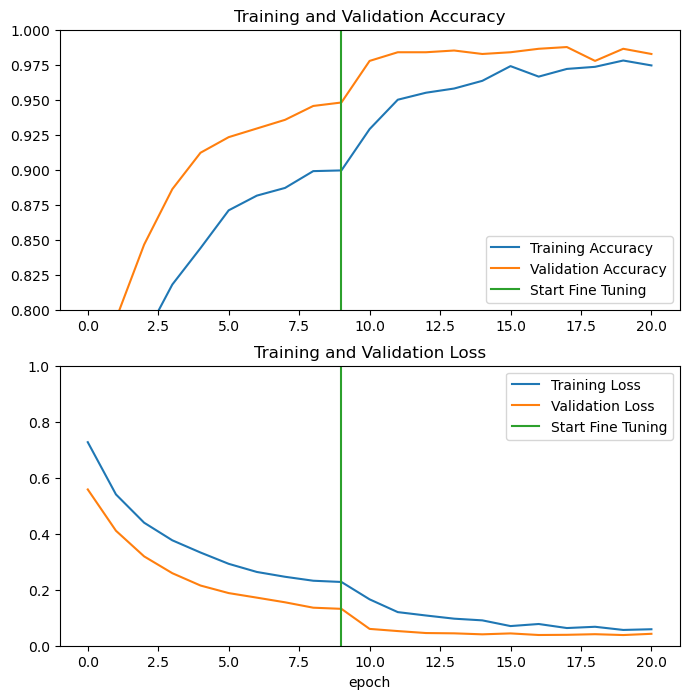

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluación y predicción

Finalmente, puede verificar el rendimiento del modelo en nuevos datos utilizando un conjunto de prueba.

In [37]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 2s 235ms/step - loss: 0.0540 - accuracy: 0.9844
Test accuracy : 0.984375


Y ahora está todo listo para usar este modelo para predecir si su mascota es un gato o un perro.

Predictions:
 [1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1]
Labels:
 [1 0 1 0 0 0 1 0 0 1 1 1 1 1 0 0 0 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1]


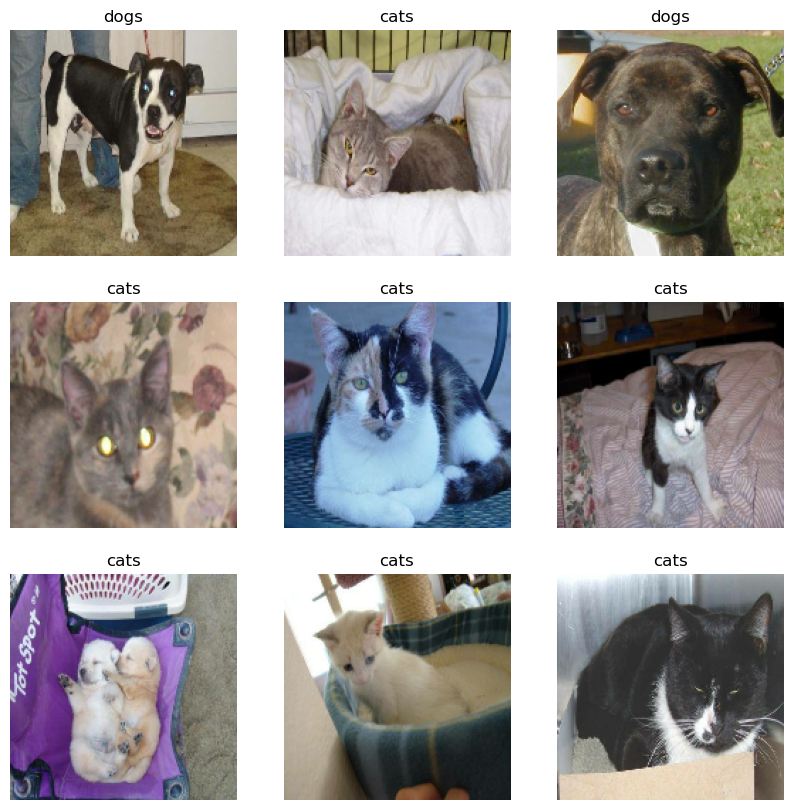

In [38]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Resumen

* **Uso de un modelo previamente entrenado para la extracción de características**: cuando se trabaja con un conjunto de datos pequeño, es una práctica común aprovechar las características aprendidas por un modelo entrenado en un conjunto de datos más grande en el mismo dominio. Esto se hace instanciando el modelo previamente entrenado y agregando un clasificador completamente conectado en la parte superior. El modelo preentrenado se "congela" y solo los pesos del clasificador se actualizan durante el entrenamiento. En este caso, la base convolucional extrajo todas las características asociadas con cada imagen y solo entrenó un clasificador que determina la clase de imagen dado ese conjunto de características extraídas.

* **Refinamiento de un modelo preentrenado**: para mejorar aún más el rendimiento, es posible que desee reutilizar las capas de nivel superior de los modelos preentrenados para el nuevo conjunto de datos a través del refinamiento. En este caso, ajustó sus ponderaciones de modo que su modelo aprendiera características de alto nivel específicas del conjunto de datos. Esta técnica generalmente se recomienda cuando el conjunto de datos de entrenamiento es grande y muy similar al conjunto de datos original en el que se entrenó el modelo previamente entrenado.

Para obtener más información, visite la [guía de aprendizaje por Transferencia](https://www.tensorflow.org/guide/keras/transfer_learning).


# **Preguntas** #

### **1. ¿En qué consiste un modelo preentrenado?** ###

Un modelo preentrenado es un modelo de aprendizaje automático que se ha entrenado en un gran conjunto de datos para una tarea específica, como la clasificación de imágenes o el procesamiento del lenguaje natural, y que ya ha aprendido a reconocer determinados patrones o características en los datos.

### **2. Sintetice en qué consiste el aprendizaje por transferencia.** ###

El aprendizaje por transferencia consiste en utilizar un modelo preentrenado como punto de partida para una nueva tarea en lugar de entrenar un nuevo modelo desde cero. El modelo preentrenado suele estar entrenado en un conjunto de datos amplio y diverso, por lo que ya ha aprendido características útiles que pueden aplicarse a la nueva tarea. El modelo preentrenado se modifica añadiendo nuevas capas sobre él, y estas nuevas capas se entrenan en un conjunto de datos más pequeño y específico para la nueva tarea.

### **3. Indique las maneras en que se realiza el aprendizaje por transferencia en el cuaderno.** ###

El aprendizaje por transferencia se realiza en el código cargando un modelo preentrenado (MobileNetV2) mediante la API Keras y añadiendo una nueva capa de clasificación sobre él. A continuación, el modelo preentrenado se congela y sólo se entrena la nueva capa de clasificación en un conjunto de datos más pequeño.

### **4. Explique por qué se usa el aumento de datos en el ejercicio y en qué consiste.** ###

El aumento de datos se utiliza para aumentar el tamaño y la diversidad del conjunto de datos de entrenamiento. Consiste en aplicar transformaciones aleatorias a las imágenes, como rotación, volteo o zoom, para crear nuevas variaciones de la misma imagen. Esto ayuda a evitar el sobreajuste y mejora la generalización del modelo.

### **5. ¿Qué procesamiento se le hace a las imágenes de entrada para alimentarlas al modelo? ¿por qué?** ###

Las imágenes de entrada se preprocesan redimensionándolas a un tamaño fijo de 224x224 píxeles y normalizando los valores de los píxeles para que estén en el intervalo [-1, 1]. Esto se hace porque el modelo preentrenado (MobileNetV2) espera imágenes de entrada de este tamaño y también está entrenado con esta normalización.

### **6. ¿De qué manera se construye el modelo de clasificación encima del modelo preentrenado?** ###

El modelo de clasificación se construye sobre el modelo MobileNetV2 preentrenado añadiendo una nueva capa de clasificación con dos nodos de salida (para las dos clases del conjunto de datos) y utilizando el modelo preentrenado como extractor de características. Las imágenes de entrada se introducen en el modelo preentrenado, y la salida de la última capa convolucional se aplana y pasa por la nueva capa de clasificación para obtener las predicciones finales. 

Esto lo vemos en los fragmentos de código 19 y 20, respectivamente:

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


### **7. ¿Cuántos parámetros se necesitan entrenar en este nuevo modelo?** ###

Sólo es necesario entrenar los parámetros de la nueva capa de clasificación en este nuevo modelo, ya que los parámetros del modelo MobileNetV2 preentrenado están congelados y no se actualizan durante el entrenamiento. En total son `1,281` parámetros. En el refinamiento son un total de `1,862,721` parámetros entrenables.

### **8. ¿En qué consiste el proceso de refinamiento de este nuevo modelo?** ###

El proceso de refinamiento de este nuevo modelo consta de dos etapas: en primer lugar, la nueva capa de clasificación se entrena en el conjunto de datos de entrenamiento durante un número fijo de épocas, mientras que el modelo MobileNetV2 preentrenado se congela; a continuación, todo el modelo se descongela y se ajusta en el conjunto de datos de entrenamiento durante otro número fijo de épocas, con una tasa de aprendizaje menor que en la primera etapa. Esto permite al modelo ajustar los pesos preentrenados y aprender características específicas de la tarea a partir de un conjunto de datos más pequeño.

## **Nota** ##

No entendí porque en algunos casos (principalmente en los bloques que entrenan el modelo) el output me salía con unos `warnings` y en otros no. Por ejemplo, en el bloque 21. Y en los bloques que entrenaban el modelo no se terminaba de generar el output aunque se ejecutara el código correctamente.